**Pipeline:**
1. Load NetCDF SST data with coordinates XC, YC, time
2. Crop to configurable regions using data processing module functions
3. Generate training samples: 14 days input → 5 days output with configurable stride
4. Compute SST anomalies relative to climatological mean
5. Save training data in optimized HDF5 format

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import preprocessing functions from module
from data.preprocessing import (
    load_theta_data,
    crop_region, 
    compute_sst_anomalies,
    generate_training_sequences,
    save_training_data_hdf5
)

## Configuration

In [2]:
# Data paths
raw_data_path = Path("data/raw")
processed_data_path = Path("data/processed")
processed_data_path.mkdir(exist_ok=True)

# Input file
input_netcdf_filename = "TPOSE6_Daily_2012_surface.nc"

# Regional bounds (in degrees)
# Data longitude range: 210.08 to 249.92 (Pacific Ocean)
# Convert to equivalent bounds within the data range
input_region_bounds = {
    'lat_min': -10.0,  # 10S
    'lat_max': 10.0,   # 10N  
    'lon_min': 210.0,  # Equivalent to 150W
    'lon_max': 250.0   # Equivalent to 110W (covers full data range)
}

output_region_bounds = {
    'lat_min': -3.0,   # 3S
    'lat_max': 5.0,    # 5N
    'lon_min': 215.0,  # Equivalent to 145W
    'lon_max': 225.0   # Equivalent to 135W
}

# Temporal configuration
input_sequence_length_days = 14
output_sequence_length_days = 5
stride_days = 3

print(f"Input region: {input_region_bounds['lat_min']}°-{input_region_bounds['lat_max']}°N, {input_region_bounds['lon_min']}°-{input_region_bounds['lon_max']}°E")
print(f"Output region: {output_region_bounds['lat_min']}°-{output_region_bounds['lat_max']}°N, {output_region_bounds['lon_min']}°-{output_region_bounds['lon_max']}°E")
print(f"Sequence: {input_sequence_length_days} days input → {output_sequence_length_days} days output, stride={stride_days} days")

Input region: -10.0°-10.0°N, 210.0°-250.0°E
Output region: -3.0°-5.0°N, 215.0°-225.0°E
Sequence: 14 days input → 5 days output, stride=3 days


## Load and Inspect Data

In [3]:
# Load SST data using module function
theta_data = load_theta_data(raw_data_path / input_netcdf_filename)

print("THETA data structure:")
print(theta_data)
print("\nCoordinate ranges:")
print(f"XC: {theta_data.XC.min().values:.2f} to {theta_data.XC.max().values:.2f}")
print(f"YC: {theta_data.YC.min().values:.2f} to {theta_data.YC.max().values:.2f}")
print(f"Time steps: {len(theta_data.time)}")
print(f"THETA shape: {theta_data.shape} (time, lat, lon)")

THETA data structure:
<xarray.DataArray 'THETA' (time: 366, YC: 84, XC: 240)> Size: 30MB
[7378560 values with dtype=float32]
Coordinates: (12/14)
    iter     (time) int64 3kB ...
  * time     (time) timedelta64[ns] 3kB 00:01:12 00:02:24 ... 01:10:48 01:12:00
  * YC       (YC) float64 672B -3.917 -3.75 -3.583 -3.417 ... 9.583 9.75 9.917
    Z        float64 8B -1.0
    drF      float32 4B ...
    PHrefC   float32 4B ...
    ...       ...
    rA       (YC, XC) float32 81kB ...
    Depth    (YC, XC) float32 81kB ...
    hFacC    (YC, XC) float32 81kB ...
    maskC    (YC, XC) bool 20kB ...
    dxF      (YC, XC) float32 81kB ...
    dyF      (YC, XC) float32 81kB ...
Attributes:
    standard_name:  THETA
    long_name:      Potential Temperature
    units:          degC

Coordinate ranges:
XC: 210.08 to 249.92
YC: -3.92 to 9.92
Time steps: 366
THETA shape: (366, 84, 240) (time, lat, lon)


## Regional Cropping Functions

In [4]:
# Crop input and output regions using module function
input_region_data = crop_region(theta_data, **input_region_bounds)
output_region_data = crop_region(theta_data, **output_region_bounds)

print(f"Input region shape: {input_region_data.shape}")
print(f"Output region shape: {output_region_data.shape}")

Input region shape: (366, 84, 240)
Output region shape: (366, 48, 60)


## Compute SST Anomalies

In [5]:
# Compute SST anomalies for input and output regions using module function
input_sst_anomalies = compute_sst_anomalies(input_region_data)
output_sst_anomalies = compute_sst_anomalies(output_region_data)

print(f"Input anomalies shape: {input_sst_anomalies.shape}")
print(f"Output anomalies shape: {output_sst_anomalies.shape}")
print(f"Anomaly range - Input: [{input_sst_anomalies.min().values:.3f}, {input_sst_anomalies.max().values:.3f}]")
print(f"Anomaly range - Output: [{output_sst_anomalies.min().values:.3f}, {output_sst_anomalies.max().values:.3f}]")

Input anomalies shape: (366, 84, 240)
Output anomalies shape: (366, 48, 60)
Anomaly range - Input: [-3.518, 4.272]
Anomaly range - Output: [-3.336, 2.080]


## Generate Training Sequences

In [6]:
# Generate training sequences using module function
input_sequences, output_sequences, sequence_dates = generate_training_sequences(
    input_sst_anomalies, output_sst_anomalies,
    input_sequence_length_days, output_sequence_length_days, stride_days
)

print(f"\nTraining data shapes:")
print(f"Input sequences: {input_sequences.shape} (samples, time, lat, lon)")
print(f"Output sequences: {output_sequences.shape} (samples, time, lat, lon)")
print(f"Date metadata: {sequence_dates.shape}")

Generating sequences: 100%|██████████| 116/116 [00:00<00:00, 2622.41it/s]


Training data shapes:
Input sequences: (116, 14, 84, 240) (samples, time, lat, lon)
Output sequences: (116, 5, 48, 60) (samples, time, lat, lon)
Date metadata: (116, 3)


## Convert to HDF5 Format and Save

In [7]:
# Save training data using HDF5 format from module
sequence_config = {
    'input_length_days': input_sequence_length_days,
    'output_length_days': output_sequence_length_days,
    'stride_days': stride_days
}

save_training_data_hdf5(
    input_sequences, output_sequences, sequence_dates,
    input_region_bounds, output_region_bounds, sequence_config,
    processed_data_path
)

print(f"Saved training data to {processed_data_path}")
print(f"HDF5 file: tiw_sst_training_data.h5")

Saved training data to data/processed
HDF5 file: tiw_sst_training_data.h5


## Data Visualization and Quality Checks

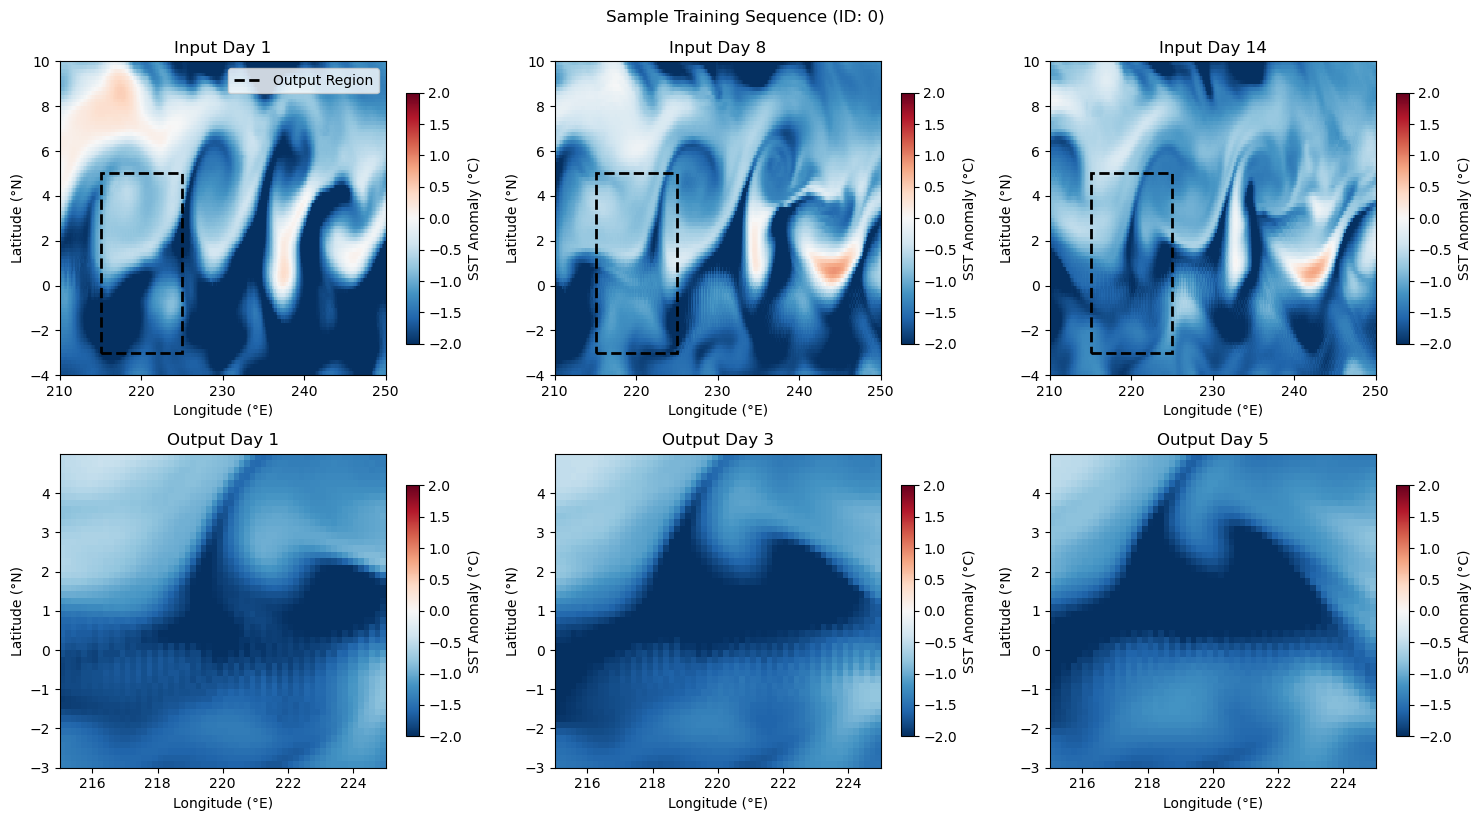

In [13]:
# Plot sample input and output sequences using xarray plotting
sample_idx = 0

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Input sequence (first, middle, last day)
input_days_to_plot = [0, input_sequence_length_days//2, input_sequence_length_days-1]
for i, day_idx in enumerate(input_days_to_plot):
    # Create xarray DataArray for plotting
    input_da = xr.DataArray(
        input_sequences[sample_idx, day_idx], 
        coords=[input_sst_anomalies.YC, input_sst_anomalies.XC],
        dims=['YC', 'XC']
    )
    im = input_da.plot(ax=axes[0, i], cmap='RdBu_r', vmin=-2, vmax=2, add_colorbar=False)
    axes[0, i].set_title(f'Input Day {day_idx+1}')
    axes[0, i].set_xlabel('Longitude (°E)')
    axes[0, i].set_ylabel('Latitude (°N)')
    
    # Add box showing output region bounds
    from matplotlib.patches import Rectangle
    output_box = Rectangle(
        (output_region_bounds['lon_min'], output_region_bounds['lat_min']),
        output_region_bounds['lon_max'] - output_region_bounds['lon_min'],
        output_region_bounds['lat_max'] - output_region_bounds['lat_min'],
        linewidth=2, edgecolor='black', facecolor='none', linestyle='--'
    )
    axes[0, i].add_patch(output_box)
    
    # Add properly sized colorbar
    cbar = plt.colorbar(im, ax=axes[0, i], shrink=0.8)
    cbar.set_label('SST Anomaly (°C)')

# Output sequence (first, middle, last day)
output_days_to_plot = [0, output_sequence_length_days//2, output_sequence_length_days-1]
for i, day_idx in enumerate(output_days_to_plot):
    # Create xarray DataArray for plotting
    output_da = xr.DataArray(
        output_sequences[sample_idx, day_idx], 
        coords=[output_sst_anomalies.YC, output_sst_anomalies.XC],
        dims=['YC', 'XC']
    )
    im = output_da.plot(ax=axes[1, i], cmap='RdBu_r', vmin=-2, vmax=2, add_colorbar=False)
    axes[1, i].set_title(f'Output Day {day_idx+1}')
    axes[1, i].set_xlabel('Longitude (°E)')
    axes[1, i].set_ylabel('Latitude (°N)')
    # Add properly sized colorbar
    cbar = plt.colorbar(im, ax=axes[1, i], shrink=0.8)
    cbar.set_label('SST Anomaly (°C)')

# Add legend for the output region box
axes[0, 0].plot([], [], 'k--', linewidth=2, label='Output Region')
axes[0, 0].legend(loc='upper right')

plt.tight_layout()
plt.suptitle(f'Sample Training Sequence (ID: {sample_idx})', y=1.02)
plt.show()

In [10]:
# Data quality summary
print("=== Data Quality Summary ===")
print(f"Total sequences: {len(sequence_dates)}")
print(f"Input sequence shape: {input_sequences.shape}")
print(f"Output sequence shape: {output_sequences.shape}")
print(f"Input anomaly statistics:")
print(f"  Mean: {np.mean(input_sequences):.4f}°C")
print(f"  Std:  {np.std(input_sequences):.4f}°C")
print(f"  Min:  {np.min(input_sequences):.4f}°C")
print(f"  Max:  {np.max(input_sequences):.4f}°C")
print(f"Output anomaly statistics:")
print(f"  Mean: {np.mean(output_sequences):.4f}°C")
print(f"  Std:  {np.std(output_sequences):.4f}°C")
print(f"  Min:  {np.min(output_sequences):.4f}°C")
print(f"  Max:  {np.max(output_sequences):.4f}°C")

# Check for NaN values
input_nans = np.isnan(input_sequences).sum()
output_nans = np.isnan(output_sequences).sum()
print(f"\nNaN values: Input={input_nans}, Output={output_nans}")

=== Data Quality Summary ===
Total sequences: 116
Input sequence shape: (116, 14, 84, 240)
Output sequence shape: (116, 5, 48, 60)
Input anomaly statistics:
  Mean: 0.0396°C
  Std:  0.9771°C
  Min:  -3.5177°C
  Max:  4.2720°C
Output anomaly statistics:
  Mean: 0.0597°C
  Std:  0.9045°C
  Min:  -3.3363°C
  Max:  2.0804°C

NaN values: Input=0, Output=0
